In [54]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

import src.DataGrabber
import src.utils
from src.utils import set_gpytorch_settings

set_gpytorch_settings()

# Command in terminal to help with memory allocation
# set PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                time  wind_dir  wind_spd  gust  wave_height  dominant_wpd  \
0       1.349049e+09     999.0      99.0  99.0          1.1          17.0   
1       1.349051e+09     999.0      99.0  99.0          1.0          17.0   
2       1.349053e+09     999.0      99.0  99.0          1.1          17.0   
3       1.349055e+09     999.0      99.0  99.0          1.0          17.0   
4       1.349057e+09     999.0      99.0  99.0          1.1          18.0   
...              ...       ...       ...   ...          ...           ...   
175393  1.678185e+09     999.0      99.0  99.0          1.1          10.0   
175394  1.678186e+09     999.0      99.0  99.0          1.1          13.0   
175395  1.678188e+09     999.0      99.0  99.0          1.1          13.0   
175396  1.678190e+09     999.0      99.0  99.0          1.1           5.0   
175397  1.678192e+09     999.0      99.0  99.0          1.1      

In [55]:
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
from src.custom_kernel import noise_lower, noise_upper, noise_init

174818
[[1.34904934e+09 2.11000004e+01]
 [1.34905114e+09 2.12000008e+01]
 [1.34905293e+09 2.15000000e+01]
 ...
 [1.67713357e+09 1.21999998e+01]
 [1.67713536e+09 1.21000004e+01]
 [1.67713715e+09 1.21000004e+01]]
7285
[[1.34907001e+09 2.04625003e+01]
 [1.34911319e+09 2.08624997e+01]
 [1.34915641e+09 2.03166668e+01]
 ...
 [1.67706426e+09 1.31416666e+01]
 [1.67710836e+09 1.27916665e+01]
 [1.39761355e+08 1.00833337e+00]]


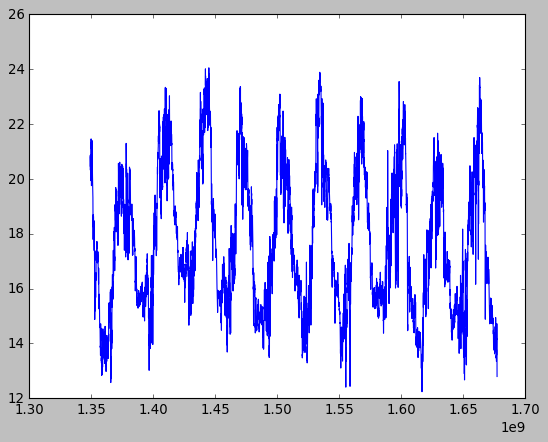

In [56]:
df = pd.read_feather('../data/feather/46221_9999_wave_height.feather')
df_as_np = df \
    .loc[:, ['time', 'sea_surface_temperature']] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
print(len(df_as_np))
print(df_as_np)
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
print(len(using_sk))
print(using_sk)
plt.plot(using_sk[:-1,0], using_sk[:-1,1])


In [57]:
(print(using_sk[:-1,1]))

[20.46250025 20.86249971 20.31666684 ... 14.1500001  13.14166661
 12.79166647]


In [58]:
X = torch.tensor(using_sk[:-1,0]).float().cuda()#.type(torch.double)
y = torch.tensor(using_sk[:-1,1]).float().cuda()#.type(torch.double)
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X
# print(X,y)
print(y)#
print(X)

tensor([20.4625, 20.8625, 20.3167,  ..., 14.1500, 13.1417, 12.7917])
tensor([[1.3491e+09],
        [1.3491e+09],
        [1.3492e+09],
        ...,
        [1.6770e+09],
        [1.6771e+09],
        [1.6771e+09]])


In [59]:
print(y.shape)
print(X.shape)
print(y.sum())

torch.Size([7283])
torch.Size([7283, 1])
tensor(129067.3203)


In [60]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)
X = scaler(X, X_old)

print(y.sum())
y = y.log()
# y = y - torch.min(y)
# y = 2 * (y / torch.max(y)) - 1
print(y.sum())

tensor(129067.3203)
tensor(20863.3555)


In [61]:
print(len(X), len(y))

7283 7283


In [62]:
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

print(train_x.min())
print(train_x.max())
print(train_x.mean())

print(test_x.min())
print(test_x.max())
print(test_x.mean())

tensor(0.1070)
tensor(1.)
tensor(0.5568)
tensor(0.8940)
tensor(1.)
tensor(0.9469)


In [63]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [64]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [65]:
Mat32 = MaternKernel(nu=1.5)
Mat12 = MaternKernel(nu=0.5)
RBF = RBFKernel()

# Per_Day = PeriodicKernel(
#     period_length_constraint=Interval(
#     lower_bound=scaler(60*24, center=False) / 100,
#     upper_bound=scaler(60*24, center=False) * 100,
#     initial_value=scaler(60*24, center=False))
# )

Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=scaler(60*24*30, center=False) / 100,
    upper_bound=scaler(60*24*30, center=False) * 100,
    initial_value=scaler(60*24*30, center=False))
)
Per_Arb = PeriodicKernel()
# kernel = (
# 	k1 + k3 + k4
#     # not: ScaleKernel(k1+k2) since they all have spectral component
# )

kernel = (
    ScaleKernel(Mat12) +
	ScaleKernel(RBF) +
    ScaleKernel(Per_Arb) +
    ScaleKernel(Per_Month)
    # ScaleKernel(Per_Day)
    # not: ScaleKernel(k1+k2) since they all have spectral component
)




In [66]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()  #(noise_constraint = Interval(noise_lower, noise_upper,initial_value=noise_init))

model = ExactGPModel(train_x, train_y, likelihood, kernel)
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50
num_epochs = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc=f'Training {model.__str__}')
for i in epochs_iter:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


Training <method-wrapper '__str__' of ExactGPModel object at 0x0000014C059A4D30>:   0%|          | 0/100 [00:0…

C:\Users\dcaos\anaconda3\envs\GPs\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 29000.583984375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


TypeError: 'Text' object is not callable

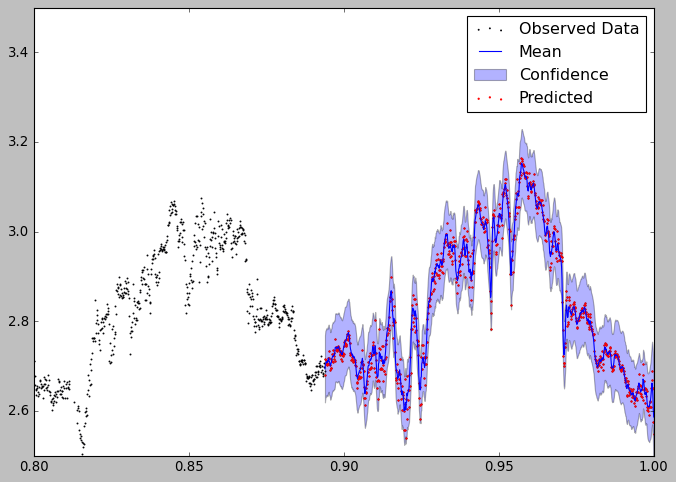

In [67]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
name_of_model = model.__name__
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = test_x
    observed_pred = likelihood(model(test_x))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

# Plot training data as black stars
ax.scatter(
    train_x[:, 0].detach().cpu().numpy(),
    train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(
    test_x.detach().cpu().numpy(),
    observed_pred.mean.detach().cpu().numpy(),
    'blue')
# Shade between the lower and upper confidence bounds
ax.fill_between(
    test_x[:,0].detach().cpu().numpy(),
    lower.detach().cpu().numpy(),
    upper.detach().cpu().numpy(), alpha=0.3)
ax.scatter(
    test_x[:,0].detach().cpu().numpy(),
    test_y.detach().cpu().numpy(),
    s=1, color="red")
ax.set_ylim([2.5, 3.5])
ax.set_xlim(.8,1)
ax.legend(['Observed Data', 'Mean', 'Confidence', 'Predicted'])
ax.title(name_of_model)

In [ ]:
# model._get_name()
# model._named_members(Tru)
# model._get_module_and_name("")